In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import librosa
import os
import pandas as pd
import glob
import numpy as np
import soundfile
from sklearn.model_selection import train_test_split

In [ ]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

In [ ]:
def extract_feature(file_name,mfcc,chroma,mel,zcr,rmse):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        if zcr:
            zcr=np.mean(librosa.feature.zero_crossing_rate(y=X, frame_length=2048, hop_length=512).T,axis=0)
            result=np.hstack((result, zcr))
        if rmse:
            rmse=np.mean(librosa.feature.rms(S=stft,frame_length=2048, hop_length=512, pad_mode='reflect').T,axis=0)
            result=np.hstack((result, rmse))
    return result

In [ ]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/content/drive/MyDrive/SER_0817/data/EMODB/wav/*.wav"):
        file_name=os.path.basename(file)
        emotion=file_name[5]
        if emotion=='W':
          e='anger'
        if emotion=='L':
          e='boredom'
        if emotion=='E':
          e='disgust'
        if emotion=='A':
          e='fear'
        if emotion=='F':
          e='happiness'
        if emotion=='T':
          e='sadness'
        if emotion=='N':
          e='neutral'
        feature=extract_feature(file,mfcc=True,chroma=True,mel=True,zcr=True,rmse=True)
        x.append(feature)
        y.append(e)
    return train_test_split(np.array(x), y, test_size=test_size, random_state = 777)

In [ ]:
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

In [ ]:
y_train.count('anger'), y_train.count('boredom'), y_train.count('disgust'), y_train.count('fear'), y_train.count('happiness'), y_train.count('sadness'), y_train.count('neutral')

(95, 65, 35, 55, 62, 49, 67)

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler
# oversample = RandomOverSampler(sampling_strategy='minority')
# X_over, y_over = oversample.fit_resample(x_train, Y_tra)
from imblearn.over_sampling import SMOTE
smote_sample = SMOTE(random_state=42)
x_sm, y_sm = smote_sample.fit_resample(x_train, y_train)

In [ ]:
y_sm.count('anger'), y_sm.count('boredom'), y_sm.count('disgust'), y_sm.count('fear'), y_sm.count('happiness'), y_sm.count('sadness'), y_sm.count('neutral')

(95, 95, 95, 95, 95, 95, 95)

In [ ]:
#- 0.5 95+55+49=199 => 285=> 199 // -0.2 65+35=100 => 190 // 0.46 67 => 95 // 0.7 62 =>95

In [ ]:
len(x_sm), len(y_sm)

(762, 762)

In [ ]:
len(x_train)

428

In [ ]:
x_train.shape, x_test.shape

((428, 182), (107, 182))

In [ ]:
y_sm.count('anger'), y_sm.count('boredom'), y_sm.count('disgust'), y_sm.count('fear'), y_sm.count('happiness'), y_sm.count('sadness'), y_sm.count('neutral')

(95, 95, 95, 55, 194, 49, 179)

In [ ]:
PAD_db = pd.read_csv('/content/drive/MyDrive/SER_0817/EMODB_cnn_lstm/PAD_data_7after_2anomal_2.csv')
PAD_db = PAD_db.iloc[:,1:]
PAD_db

,term,P,A,D
0,anger,-0.454444,0.551111,0.182222
1,boredom,-0.131875,-0.351250,-0.194375
2,disgust,-0.280667,0.275333,0.186667
3,anxiety_fear,-0.564615,0.436923,-0.359231
4,happiness,0.703158,0.335263,0.418947
5,sadness,-0.586818,-0.137273,-0.325000
6,neutral,0.462143,-0.045714,-0.080000


In [ ]:
x_sm_p = copy.deepcopy(x_sm)
y_sm_p = copy.deepcopy(y_sm)

In [ ]:
x_sm_a = copy.deepcopy(x_sm)
y_sm_a = copy.deepcopy(y_sm)

In [ ]:
import copy
Y_train_p = copy.deepcopy(y_sm_p)
# Y_train = Y_train.tolist()
Y_test = copy.deepcopy(y_test)
# Y_test = Y_test.tolist()

ange = [x for y in (PAD_db[PAD_db['term']=='anger'])[['P']].values for x in y]
bore = [x for y in (PAD_db[PAD_db['term']=='boredom'])[['P']].values for x in y]
disg = [x for y in (PAD_db[PAD_db['term']=='disgust'])[['P']].values for x in y]
fea_ = [x for y in (PAD_db[PAD_db['term']=='anxiety_fear'])[['P']].values for x in y]
happ = [x for y in (PAD_db[PAD_db['term']=='happiness'])[['P']].values for x in y]
sadn = [x for y in (PAD_db[PAD_db['term']=='sadness'])[['P']].values for x in y]
neut = [x for y in (PAD_db[PAD_db['term']=='neutral'])[['P']].values for x in y]

y_train_p = []
for i in Y_train_p:
  if i == 'neutral':
    y_train_p.append(neut)
  elif i == 'anger':
    y_train_p.append(ange)
  elif i == 'sadness':
    y_train_p.append(sadn)
  elif i == 'happiness':
    y_train_p.append(happ)
  elif i == 'fear':
    y_train_p.append(fea_)
  elif i == 'disgust':
    y_train_p.append(disg)
  elif i == 'boredom':
    y_train_p.append(bore)
  else:
    continue

y_test_p = []
for i in Y_test:
  if i == 'neutral':
    y_test_p.append(neut)
  elif i == 'anger':
    y_test_p.append(ange)
  elif i == 'sadness':
    y_test_p.append(sadn)
  elif i == 'happiness':
    y_test_p.append(happ)
  elif i == 'fear':
    y_test_p.append(fea_)
  elif i == 'disgust':
    y_test_p.append(disg)
  elif i == 'boredom':
    y_test_p.append(bore)
  else:
    continue
y_train_p = np.array(y_train_p)
y_test_p = np.array(y_test_p)

In [ ]:
import copy
Y_train_a = copy.deepcopy(y_sm_a)
# Y_train = Y_train.tolist()
Y_test = copy.deepcopy(y_test)
# Y_test = Y_test.tolist()
ange = [x for y in (PAD_db[PAD_db['term']=='anger'])[['A']].values for x in y]
bore = [x for y in (PAD_db[PAD_db['term']=='boredom'])[['A']].values for x in y]
disg = [x for y in (PAD_db[PAD_db['term']=='disgust'])[['A']].values for x in y]
fea_ = [x for y in (PAD_db[PAD_db['term']=='anxiety_fear'])[['A']].values for x in y]
happ = [x for y in (PAD_db[PAD_db['term']=='happiness'])[['A']].values for x in y]
sadn = [x for y in (PAD_db[PAD_db['term']=='sadness'])[['A']].values for x in y]
neut = [x for y in (PAD_db[PAD_db['term']=='neutral'])[['A']].values for x in y]

y_train_a = []
for i in Y_train_a:
  if i == 'neutral':
    y_train_a.append(neut)
  elif i == 'anger':
    y_train_a.append(ange)
  elif i == 'sadness':
    y_train_a.append(sadn)
  elif i == 'happiness':
    y_train_a.append(happ)
  elif i == 'fear':
    y_train_a.append(fea_)
  elif i == 'disgust':
    y_train_a.append(disg)
  elif i == 'boredom':
    y_train_a.append(bore)
  else:
    continue

y_test_a = []
for i in Y_test:
  if i == 'neutral':
    y_test_a.append(neut)
  elif i == 'anger':
    y_test_a.append(ange)
  elif i == 'sadness':
    y_test_a.append(sadn)
  elif i == 'happiness':
    y_test_a.append(happ)
  elif i == 'fear':
    y_test_a.append(fea_)
  elif i == 'disgust':
    y_test_a.append(disg)
  elif i == 'boredom':
    y_test_a.append(bore)
  else:
    continue
y_train_a = np.array(y_train_a)
y_test_a = np.array(y_test_a)

In [ ]:
import copy
Y_train = copy.deepcopy(y_sm)
# Y_train = Y_train.tolist()
Y_test = copy.deepcopy(y_test)
# Y_test = Y_test.tolist()
ange = [x for y in (PAD_db[PAD_db['term']=='anger'])[['D']].values for x in y]
bore = [x for y in (PAD_db[PAD_db['term']=='boredom'])[['D']].values for x in y]
disg = [x for y in (PAD_db[PAD_db['term']=='disgust'])[['D']].values for x in y]
fea_ = [x for y in (PAD_db[PAD_db['term']=='anxiety_fear'])[['D']].values for x in y]
happ = [x for y in (PAD_db[PAD_db['term']=='happiness'])[['D']].values for x in y]
sadn = [x for y in (PAD_db[PAD_db['term']=='sadness'])[['D']].values for x in y]
neut = [x for y in (PAD_db[PAD_db['term']=='neutral'])[['D']].values for x in y]

Y_tra = []
for i in Y_train:
  if i == 'neutral':
    Y_tra.append(neut)
  elif i == 'anger':
    Y_tra.append(ange)
  elif i == 'sadness':
    Y_tra.append(sadn)
  elif i == 'happiness':
    Y_tra.append(happ)
  elif i == 'fear':
    Y_tra.append(fea_)
  elif i == 'disgust':
    Y_tra.append(disg)
  elif i == 'boredom':
    Y_tra.append(bore)
  else:
    continue

Y_tes = []
for i in Y_test:
  if i == 'neutral':
    Y_tes.append(neut)
  elif i == 'anger':
    Y_tes.append(ange)
  elif i == 'sadness':
    Y_tes.append(sadn)
  elif i == 'happiness':
    Y_tes.append(happ)
  elif i == 'fear':
    Y_tes.append(fea_)
  elif i == 'disgust':
    Y_tes.append(disg)
  elif i == 'boredom':
    Y_tes.append(bore)
  else:
    continue
Y_tra = np.array(Y_tra)
Y_tes = np.array(Y_tes)

In [ ]:
# y_train=np.array(y_train)
# y_test=np.array(y_test)

In [ ]:
# lb = LabelEncoder()
# y_train = to_categorical(lb.fit_transform(y_train))
# y_test = to_categorical(lb.fit_transform(y_test))

In [ ]:
y_train_p.shape

(762, 1)

In [ ]:
x_train = x_sm_p[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]
x_train.shape

(762, 182, 1)

In [ ]:
len(Y_tra)

765

In [ ]:
len(y_train_p)

762

In [ ]:
len(y_test_p)

107

In [ ]:
len(x_test)

107

In [ ]:
x_test.shape

(107, 182, 1)

In [ ]:
def my_huber_loss(y_true, y_pred):
    threshold = 1
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= threshold
    small_error_loss = tf.square(error) / 2
    big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
    return tf.where(is_small_error, small_error_loss, big_error_loss)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='linear'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=my_huber_loss, optimizer=opt,metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 173, 64)           704       
                                                                 
 conv1d_28 (Conv1D)          (None, 164, 128)          82048     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 20, 128)          0         
 g1D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 20, 128)           0         
                                                                 
 conv1d_29 (Conv1D)          (None, 11, 128)           163968    
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 1, 128)           0         
 g1D)                                                 

In [ ]:
stop_early = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=10)
checkpoint = ModelCheckpoint(
    'cnn_r.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)

In [ ]:
import tensorflow.keras as keras
model_history=model.fit(x_train, y_train_p,batch_size=32, epochs=150, callbacks=[checkpoint,stop_early], validation_data=(x_test, y_test_p))

Epoch 1/150
24/24 [==============================] - ETA: 0s - loss: 2.0658 - mean_squared_error: 10.1670
Epoch 1: val_loss improved from inf to 0.93002, saving model to cnn_r.h5
24/24 [==============================] - 6s 158ms/step - loss: 2.0658 - mean_squared_error: 10.1670 - val_loss: 0.9300 - val_mean_squared_error: 0.2823
Epoch 2/150
24/24 [==============================] - ETA: 0s - loss: 1.0595 - mean_squared_error: 0.9490
Epoch 2: val_loss improved from 0.93002 to 0.86503, saving model to cnn_r.h5
24/24 [==============================] - 3s 110ms/step - loss: 1.0595 - mean_squared_error: 0.9490 - val_loss: 0.8650 - val_mean_squared_error: 0.3003
Epoch 3/150
24/24 [==============================] - ETA: 0s - loss: 0.8748 - mean_squared_error: 0.4525
Epoch 3: val_loss improved from 0.86503 to 0.77154, saving model to cnn_r.h5
24/24 [==============================] - 3s 111ms/step - loss: 0.8748 - mean_squared_error: 0.4525 - val_loss: 0.7715 - val_mean_squared_error: 0.2623
Epo

In [ ]:
predict = model.predict(x_test)
# loss, accu = model.evaluate(X_test,Y_test,verbose=1)

4/4 [==============================] - 0s 23ms/step


In [ ]:
max(predict)

array([0.7119901], dtype=float32)

In [ ]:
import pickle

with open("/content/drive/MyDrive/SER_0817/EMODB_CNN_MLP/p_hubor_cnnregressor_smo.pickle","wb") as f:
    pickle.dump(predict, f)

In [ ]:
predict

array([[-3.31034392e-01],
       [ 1.11979507e-01],
       [ 1.70224980e-01],
       [-1.95773870e-01],
       [-3.93155873e-01],
       [ 4.14532721e-02],
       [-1.95559770e-01],
       [-5.15472405e-02],
       [-1.99716479e-01],
       [ 4.41757977e-01],
       [ 8.09634998e-02],
       [ 6.49692237e-01],
       [ 3.56978059e-01],
       [-3.04133259e-02],
       [-1.92346796e-01],
       [ 5.23876011e-01],
       [-1.24827974e-01],
       [ 1.21460110e-01],
       [ 4.34424639e-01],
       [-2.95807362e-01],
       [-8.71308967e-02],
       [-1.14430435e-01],
       [-2.98739195e-01],
       [-2.85258353e-01],
       [-1.56841591e-01],
       [-3.59564900e-01],
       [ 1.43094361e-02],
       [-4.22193050e-01],
       [-2.85659969e-01],
       [-7.87619129e-02],
       [ 5.25265872e-01],
       [-2.46103525e-01],
       [-1.65957138e-01],
       [ 2.37328231e-01],
       [ 2.50589669e-01],
       [-4.93051350e-01],
       [-3.80109787e-01],
       [ 5.85097015e-01],
       [-2.2

In [ ]:
y_test_p

array([[-0.45444444],
       [-0.45444444],
       [-0.28066667],
       [-0.131875  ],
       [-0.58681818],
       [-0.45444444],
       [-0.45444444],
       [-0.45444444],
       [-0.45444444],
       [-0.56461538],
       [-0.56461538],
       [ 0.70315789],
       [-0.131875  ],
       [-0.131875  ],
       [-0.58681818],
       [ 0.46214286],
       [-0.56461538],
       [-0.131875  ],
       [ 0.46214286],
       [-0.131875  ],
       [-0.58681818],
       [-0.28066667],
       [ 0.46214286],
       [-0.131875  ],
       [-0.28066667],
       [-0.45444444],
       [-0.45444444],
       [-0.58681818],
       [-0.56461538],
       [-0.45444444],
       [-0.45444444],
       [-0.45444444],
       [-0.45444444],
       [-0.131875  ],
       [-0.45444444],
       [-0.131875  ],
       [-0.45444444],
       [ 0.70315789],
       [-0.56461538],
       [-0.45444444],
       [-0.45444444],
       [-0.45444444],
       [-0.45444444],
       [ 0.46214286],
       [-0.56461538],
       [-0

In [ ]:
max(predict)

array([0.7583467], dtype=float32)

In [ ]:
pred_d = predict

In [ ]:
pred_a = predict

In [ ]:
pred_p = predict

In [ ]:
pred_p_1 = predict # 실수로 마지막 check 포인트 기준으로 함 아마 과적합

In [ ]:
pre = []
for i in range(len(pred_p)):
  pr = []
  pr.extend(pred_p[i].tolist())
  pr.extend(pred_a[i].tolist())
  pr.extend(pred_d[i].tolist())
  pre.append(pr)
pre

[[-0.31763267517089844, -0.13487394154071808, -0.13487394154071808],
 [0.17840330302715302, -0.13037699460983276, -0.13037699460983276],
 [-0.43831169605255127, 0.12053760141134262, 0.12053760141134262],
 [0.1016537994146347, -0.12950284779071808, -0.12950284779071808],
 [0.447232186794281, 0.30271390080451965, 0.30271390080451965],
 [-0.22738215327262878, 0.49412935972213745, 0.49412935972213745],
 [0.02651042863726616, -0.1229613646864891, -0.1229613646864891],
 [-0.22634120285511017, 0.43956372141838074, 0.43956372141838074],
 [-0.2778710126876831, 0.41501733660697937, 0.41501733660697937],
 [-0.21490250527858734, 0.42528510093688965, 0.42528510093688965],
 [-0.11171342432498932, 0.4712715744972229, 0.4712715744972229],
 [0.2969433665275574, -0.17238101363182068, -0.17238101363182068],
 [-0.007814336568117142, 0.4770524501800537, 0.4770524501800537],
 [-0.1429116427898407, 0.4801791310310364, 0.4801791310310364],
 [0.10060781240463257, -0.03010731376707554, -0.03010731376707554],
 [

In [ ]:
import pickle

with open("/content/drive/MyDrive/SER_0817/EMODB_CNN_MLP/nsingle_hubor_cnnregressor_smo.pickle","wb") as f:
    pickle.dump(pre, f)

In [ ]:
import math
def decoding(predict_value,db):

  dec = []

  for i in range(len(predict_value)):
    score = []
    decoding_label = ''
    anger_score = math.sqrt((((db[db['term']=='anger']['P']).values).tolist()[0] - predict_value[i][0])**2 + (((db[db['term']=='anger']['A']).values).tolist()[0] - predict_value[i][1])**2 + (((db[db['term']=='anger']['D']).values).tolist()[0] - predict_value[i][2])**2)
    boredom_score = math.sqrt((((db[db['term']=='boredom']['P']).values).tolist()[0] - predict_value[i][0])**2 + (((db[db['term']=='anger']['A']).values).tolist()[0] - predict_value[i][1])**2 + (((db[db['term']=='anger']['D']).values).tolist()[0] - predict_value[i][2])**2)
    disgust_score = math.sqrt((((db[db['term']=='disgust']['P']).values).tolist()[0] - predict_value[i][0])**2 + (((db[db['term']=='anger']['A']).values).tolist()[0] - predict_value[i][1])**2 + (((db[db['term']=='anger']['D']).values).tolist()[0] - predict_value[i][2])**2)
    fear_score = math.sqrt((((db[db['term']=='anxiety_fear']['P']).values).tolist()[0] - predict_value[i][0])**2 + (((db[db['term']=='anger']['A']).values).tolist()[0] - predict_value[i][1])**2 + (((db[db['term']=='anger']['D']).values).tolist()[0] - predict_value[i][2])**2)
    happiness_score = math.sqrt((((db[db['term']=='happiness']['P']).values).tolist()[0] - predict_value[i][0])**2 + (((db[db['term']=='anger']['A']).values).tolist()[0] - predict_value[i][1])**2 + (((db[db['term']=='anger']['D']).values).tolist()[0] - predict_value[i][2])**2)
    sadness_score = math.sqrt((((db[db['term']=='sadness']['P']).values).tolist()[0] - predict_value[i][0])**2 + (((db[db['term']=='anger']['A']).values).tolist()[0] - predict_value[i][1])**2 + (((db[db['term']=='anger']['D']).values).tolist()[0] - predict_value[i][2])**2)
    neutral_score = math.sqrt((((db[db['term']=='neutral']['P']).values).tolist()[0] - predict_value[i][0])**2 + (((db[db['term']=='anger']['A']).values).tolist()[0] - predict_value[i][1])**2 + (((db[db['term']=='anger']['D']).values).tolist()[0] - predict_value[i][2])**2)

    score = [anger_score, boredom_score, disgust_score, fear_score, happiness_score, sadness_score, neutral_score]

    final_score = min(score)


    if final_score == anger_score:
      decoding_label ='anger'
    elif final_score == boredom_score:
      decoding_label ='boredom'
    elif final_score == disgust_score:
      decoding_label ='disgust'
    elif final_score == fear_score:
      decoding_label ='fear'
    elif final_score == happiness_score:
      decoding_label ='happiness'
    elif final_score == sadness_score:
      decoding_label ='sadness'
    elif final_score == neutral_score:
      decoding_label ='neutral'
    else:
      continue

    dec.append(decoding_label)

  return dec

In [ ]:
pred_dec = decoding(pre, PAD_db)
pred_dec

In [ ]:
y_test

In [ ]:
le = LabelEncoder( ).fit(y_test)
tr = le.transform(y_test)
pr = le.transform(pred_dec)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

## performance metrics
accuracy = accuracy_score(tr, pr)

precision, recall, fscore, support = \
    precision_recall_fscore_support(tr, pr)

print('Accuracy   : %.3f' %accuracy)
print('Precision  : %.3f' %precision[0])
print('Recall     : %.3f' %recall[0])
print('Specificyty: %.3f' %recall[1])
print('F1-Score   : %.3f' %fscore[0])

Accuracy   : 0.206
Precision  : 0.111
Recall     : 0.037
Specificyty: 0.455
F1-Score   : 0.056


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
######################

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

## performance metrics
accuracy = accuracy_score(tr, pr)

precision, recall, fscore, support = \
    precision_recall_fscore_support(tr, pr)

print('Accuracy   : %.3f' %accuracy)
print('Precision  : %.3f' %precision[0])
print('Recall     : %.3f' %recall[0])
print('Specificyty: %.3f' %recall[1])
print('F1-Score   : %.3f' %fscore[0])

Accuracy   : 0.252
Precision  : 1.000
Recall     : 0.150
Specificyty: 0.818
F1-Score   : 0.261


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pickle

with open("/content/drive/MyDrive/SER_0817/EMODB_cnn_lstm/nsingle_hubor.pickle","rb") as f:
    pre_2 = pickle.load(f)

In [ ]:
pred_dec_2 = decoding(pre_2, PAD_db)
pred_dec_2

In [ ]:
y_test_2 = [[ 0.46214286, -0.04571429, -0.08],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.58681818, -0.13727273, -0.325     ],
       [ 0.70315789,  0.33526316,  0.41894737],
       [-0.56461538,  0.43692308, -0.35923077],
       [ 0.46214286, -0.04571429, -0.08      ],
       [ 0.70315789,  0.33526316,  0.41894737],
       [-0.58681818, -0.13727273, -0.325     ],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.131875  , -0.35125   , -0.194375  ],
       [-0.45444444,  0.55111111,  0.18222222],
       [ 0.46214286, -0.04571429, -0.08      ],
       [ 0.70315789,  0.33526316,  0.41894737],
       [-0.45444444,  0.55111111,  0.18222222],
       [ 0.70315789,  0.33526316,  0.41894737],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.56461538,  0.43692308, -0.35923077],
       [-0.28066667,  0.27533333,  0.18666667],
       [-0.56461538,  0.43692308, -0.35923077],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.58681818, -0.13727273, -0.325     ],
       [-0.45444444,  0.55111111,  0.18222222],
       [ 0.46214286, -0.04571429, -0.08      ],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.56461538,  0.43692308, -0.35923077],
       [-0.131875  , -0.35125   , -0.194375  ],
       [-0.58681818, -0.13727273, -0.325     ],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.131875  , -0.35125   , -0.194375  ],
       [-0.131875  , -0.35125   , -0.194375  ],
       [-0.131875  , -0.35125   , -0.194375  ],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.58681818, -0.13727273, -0.325     ],
       [-0.131875  , -0.35125   , -0.194375  ],
       [ 0.46214286, -0.04571429, -0.08      ],
       [-0.28066667,  0.27533333,  0.18666667],
       [-0.28066667,  0.27533333,  0.18666667],
       [ 0.70315789,  0.33526316,  0.41894737],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.56461538,  0.43692308, -0.35923077],
       [ 0.70315789,  0.33526316,  0.41894737],
       [-0.131875  , -0.35125   , -0.194375  ],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.58681818, -0.13727273, -0.325     ],
       [-0.56461538,  0.43692308, -0.35923077],
       [-0.45444444,  0.55111111,  0.18222222],
       [-0.56461538,  0.43692308, -0.35923077],
       [ 0.70315789,  0.33526316,  0.41894737],
       [ 0.46214286, -0.04571429, -0.08      ],
       [-0.45444444,  0.55111111,  0.18222222]]

In [ ]:
y_test_2 = np.array(y_test_2)
y_test_2

In [ ]:
y_test_2 = decoding(y_test_2, PAD_db)
y_test_2

In [ ]:
le_2 = LabelEncoder( ).fit(y_test_2)
tr_1 = le_2.transform(y_test_2)
pr_1 = le_2.transform(pred_dec_2)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

## performance metrics
accuracy = accuracy_score(tr_1, pr_1)

precision, recall, fscore, support = \
    precision_recall_fscore_support(tr_1, pr_1)

print('Accuracy   : %.3f' %accuracy) # (102+164)/(102+16+3+164)
print('Precision  : %.3f' %precision[0]) # 102/(102+3)
print('Recall     : %.3f' %recall[0]) # 102/(102+16)
print('Specificyty: %.3f' %recall[1]) # 164/(3+164)
print('F1-Score   : %.3f' %fscore[0]) # 2/(1/precision + 1/recall) = 2/(1/0.971+1/0.864)

Accuracy   : 0.185
Precision  : 0.429
Recall     : 0.167
Specificyty: 0.143
F1-Score   : 0.240


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------

In [ ]:
#PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

4/4 [==============================] - 0s 17ms/step - loss: 1.5372 - accuracy: 0.7009
Loss of the model is -  1.5372381210327148
4/4 [==============================] - 0s 16ms/step - loss: 1.5372 - accuracy: 0.7009
Accuracy of the model is -  70.09345889091492 %


4/4 [==============================] - 0s 16ms/step


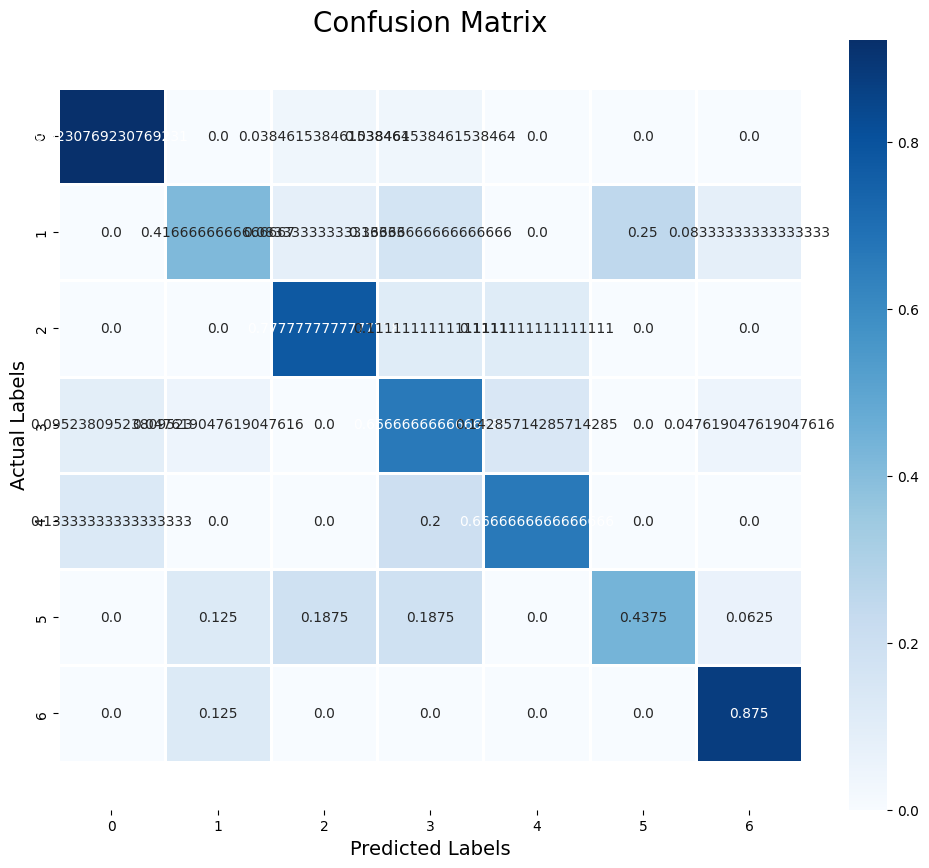

In [ ]:
predictions = model.predict(x_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
cm = confusion_matrix(actual, predictions,normalize='true')
plt.figure(figsize = (12, 10))
conf_matrix= pd.DataFrame(cm,columns=None)
conf_matrix.to_csv(r'E:\confusion_matrix.csv', index = False, header=False)
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [ ]:
print(classification_report(actual, predictions, target_names = ['anger','boredom','disgust','fear','happiness','neutral','sadness']))

              precision    recall  f1-score   support

       anger       0.86      0.92      0.89        26
     boredom       0.56      0.42      0.48        12
     disgust       0.58      0.78      0.67         9
        fear       0.58      0.67      0.62        21
   happiness       0.71      0.67      0.69        15
     neutral       0.70      0.44      0.54        16
     sadness       0.70      0.88      0.78         8

    accuracy                           0.69       107
   macro avg       0.67      0.68      0.67       107
weighted avg       0.69      0.69      0.68       107



In [ ]:
from imblearn.metrics import specificity_score
s=specificity_score(actual,predictions,average='macro')
print(s)

0.9477806026746267


In [ ]:
from sklearn.metrics import roc_auc_score
y_score=model.predict(x_test)
auc=roc_auc_score(y_test, y_score, average='macro',multi_class='ovo')
print(auc)

4/4 [==============================] - 0s 16ms/step
0.8955939958331643


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
p=precision_score(actual,predictions,average='macro')
r=recall_score(actual,predictions,average='macro')
f=f1_score(actual,predictions,average='macro')
print(p,r,f)

0.6705215419501134 0.6804792429792429 0.6656946775173376


In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(TPR)
print(FPR)

[0.92307692 0.41666667 0.77777778 0.66666667 0.66666667 0.4375
 0.875     ]
[0.03809524 0.04960317 0.05154915 0.11728989 0.04232804 0.04166667
 0.03224206]


In [ ]:
l=[]
for i in range(100):
  l.append(i+1)

In [ ]:
from pandas import DataFrame
C = {'epoch no':l,
    'acc train':model_history.history['accuracy'],
    'acc val':model_history.history['val_accuracy'],
    'loss train':model_history.history['loss'],
    'loss val':model_history.history['val_loss']}
df = DataFrame(C, columns= ['epoch no','acc train','acc val','loss train','loss val'])
export_csv = df.to_csv (r'E:\result1.csv', index = None, header=True)
print (df)

    epoch no  acc train   acc val  loss train  loss val
0          1   0.163551  0.392523    5.429076  2.709029
1          2   0.301402  0.345794    3.048714  2.553494
2          3   0.357477  0.364486    2.643586  2.372539
3          4   0.390187  0.392523    2.427150  2.364021
4          5   0.401869  0.420561    2.289222  2.270646
..       ...        ...       ...         ...       ...
95        96   0.878505  0.710280    0.553373  1.516609
96        97   0.883178  0.663551    0.581122  1.695514
97        98   0.892523  0.747664    0.506798  1.611288
98        99   0.922897  0.775701    0.454368  1.408566
99       100   0.890187  0.700935    0.506819  1.537238

[100 rows x 5 columns]


In [ ]:
from pandas import DataFrame
C = {
     'train acc':[str(model_history.history['accuracy'][99])],
     'test acc':[str(model_history.history['val_accuracy'][99])],
     'precision(macro)':[str(p)],
     'recall(macro)':[str(r)],
     'f1(macro)':[str(f)],
     'specificity(macro)':[str(s)],
     'AUC(macro)':[str(auc)],
     'train time per epoch':['1 sec'],
     'test time per epoch':['1 sec'],}
df = DataFrame(C, columns= ['train acc','test acc','precision(macro)','recall(macro)','f1(macro)','specificity(macro)','AUC(macro)','train time per epoch','test time per epoch'])
export_csv = df.to_csv (r'E:\result2.csv', index = None, header=True)
print (df)

            train acc            test acc    precision(macro)  \
0  0.8901869058609009  0.7009345889091492  0.6705215419501134   

        recall(macro)           f1(macro)  specificity(macro)  \
0  0.6804792429792429  0.6656946775173376  0.9477806026746267   

           AUC(macro) train time per epoch test time per epoch  
0  0.8955939958331643                1 sec               1 sec  


In [ ]:
from pandas import DataFrame
C = {
     'TPR': TPR,
     'FPR': FPR}
df = DataFrame(C, columns= ['TPR','FPR'])
export_csv = df.to_csv (r'E:\result3.csv', index = None, header=True)
print (df)

        TPR       FPR
0  0.923077  0.038095
1  0.416667  0.049603
2  0.777778  0.051549
3  0.666667  0.117290
4  0.666667  0.042328
5  0.437500  0.041667
6  0.875000  0.032242
